# The Dense Module

At last, we have trained, tested, and run the temporal module: https://colab.research.google.com/drive/1NnGjT80qrxxq4teM7m2gvs80TkwNXMjs?usp=sharing.

And the spatial module: https://colab.research.google.com/drive/1BPraySSp7ymHibXc90oa3QuevrqMRop9?usp=sharing

In [ ]:
!git clone https://github.com/rdemedrano/crann_traffic.git
%cd crann_traffic/
%cd Dense\ module
!pip install configargparse

Cloning into 'crann_traffic'...
remote: Enumerating objects: 224, done.
remote: Counting objects: 100% (224/224), done.
remote: Compressing objects: 100% (173/173), done.
remote: Total 224 (delta 60), reused 198 (delta 45), pack-reused 0
Receiving objects: 100% (224/224), 30.09 MiB | 4.13 MiB/s, done.
Resolving deltas: 100% (60/60), done.
/content/crann_traffic
/content/crann_traffic/Dense module


In [ ]:
import sys
import os
import json
import numpy as np

import torch

from dataset import data_transform
from utils import DotDict, Logger, evaluate_temp_att, denormalize_data, rmse, bias, rel_error
from dense import MLP
sys.path.append('../Spatial module/') 
from sp_att_mech import AttentionCNN
sys.path.append('../Temporal module/') 
from bahdanau_att import EncoderLSTM, BahdanauDecoder

import matplotlib.pyplot as plt
%matplotlib inline

Data importation & visualisation

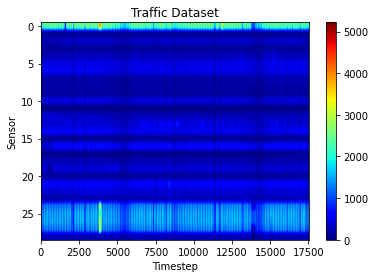

In [ ]:
datadir = 'data'
dataset = 'dense_data.csv'
data = torch.Tensor(np.genfromtxt(os.path.join('..',datadir, dataset)))

plt.figure('Traffic Dataset')
plt.imshow(data[:,1:30].squeeze().numpy().T, aspect='auto', cmap='jet')
plt.title('Traffic Dataset')
plt.xlabel('Timestep')
plt.ylabel('Sensor')
plt.colorbar()

The dense module requires the trained data from the last 2 modules as the input, and obtained the raster multidimensional (3D+) tensor of traffic prediction as the output. This last submodel can take up to 100 minutes to train.

In [ ]:
run training.py

 25%|██▌       | 50/200 [10:03<30:09, 12.06s/it, lr=1e-5, train_mse=0.0101, train_rmse=0.101, val_mse=0.00951, val_rmse=0.0975]




 *  Test MSE:  67154.6171875 
 *  Test RMSE:  259.14207915253746 
 *  Test Bias:  -7.114506244659424 
 *  Test Rel-Err (%):  24.76968914270401



<Figure size 432x288 with 0 Axes>


RESULTS
Example: mean prediction from 00:00 to 23:00
Learning curve
Error distribution: spatial and temporal

In [ ]:
outputdir  = opt.outputdir
with open(os.path.join(outputdir, 'logs.json'), 'r') as f:
    logs = json.load(f)
    
with open(os.path.join(outputdir, 'config.json'), 'r') as f:
    config = json.load(f)

opt = DotDict(config)

In [ ]:
# DENSE
inputs = opt.n_out_sp*(opt.n_points + opt.n_exo + 1) 
outputs = opt.n_out_sp*opt.n_points

model = MLP(n_inputs=inputs + opt.n_ar*opt.n_points, n_outputs=outputs, n_layers=opt.n_layers_dns, n_hidden=opt.n_hidden_dns)
model.to(device)
model.load_state_dict(torch.load(os.path.join(outputdir, 'spatial_model.pt')))

# ESPACIAL
spatial_model = AttentionCNN(in_channels=opt.n_inp_sp, out_channels=opt.n_out_sp, dim_x=opt.dim_x, dim_y=opt.dim_y)
spatial_model.to(device)
spatial_model.load_state_dict(torch.load("../Trained models/spatial_model.pth"))

# TEMPORAL
temporal_encoder = EncoderLSTM(opt.in_dim_tem, opt.n_hidden_tem, device=device)
temporal_encoder.to(device)
temporal_encoder.load_state_dict(torch.load("../Trained models/encoder.pth"))
temporal_decoder = BahdanauDecoder(opt.n_hidden_tem, opt.out_dim_tem)
temporal_decoder.to(device)
temporal_decoder.load_state_dict(torch.load("../Trained models/decoder.pth"))

<All keys matched successfully>

In [ ]:
_, _, _, _, X_test_time, _, _, _, \
_, _, _, _, X_test_space, Y_test, min_value_space, max_value_space, \
_, _, X_test_exo, _, _ = data_transform(opt)

test_dataset = []
for i in range(len(Y_test)):
   test_dataset.append([X_test_time[i], X_test_space[i], X_test_exo[i], Y_test[i]]) 
    

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = len(Y_test),
                                           shuffle = False)

In [ ]:
model.eval()
spatial_model.eval()
temporal_encoder.eval()
temporal_decoder.eval()
with torch.no_grad():        
    for x_time, x_space, x_exo, y in test_loader:
        if torch.cuda.is_available():
            x_time = x_time.view(-1, opt.n_inp_tem, opt.in_dim_tem).to(device)
            x_space = x_space.to(device)
            x_exo = x_exo.to(device)
            y = y.to(device)
        else:
            x_time = x_time
            x_space = x_space
            x_exo = x_exo
            y = y
        y_time = evaluate_temp_att(temporal_encoder, temporal_decoder, x_time, opt.n_out_sp, device)
        y_space, _ = spatial_model(x_space)
        x = torch.cat((y_time.unsqueeze(2), y_space.squeeze().view(-1,opt.n_out_sp,opt.n_points), x_exo), dim = 2).view(-1, inputs)
        x = torch.cat((x,x_space[:,-opt.n_ar:].view(-1,opt.n_ar*opt.n_points)), dim = 1)
        y_pred = model(x).view(-1,opt.n_out_sp,opt.dim_x,opt.dim_y)
        
        y_dnorm = denormalize_data(y.view(-1, opt.n_out_sp, opt.n_points).cpu(), min_value_space, max_value_space)
        y_pred_dnorm = denormalize_data(y_pred.view(-1, opt.n_out_sp, opt.n_points).cpu(), min_value_space, max_value_space)

y_tstep = y_dnorm[1::24]
y_pred_tstep = y_pred_dnorm[1::24]

Example of the autoencoding/prediction process:

Text(0.5, 1.0, 'Absolute error')

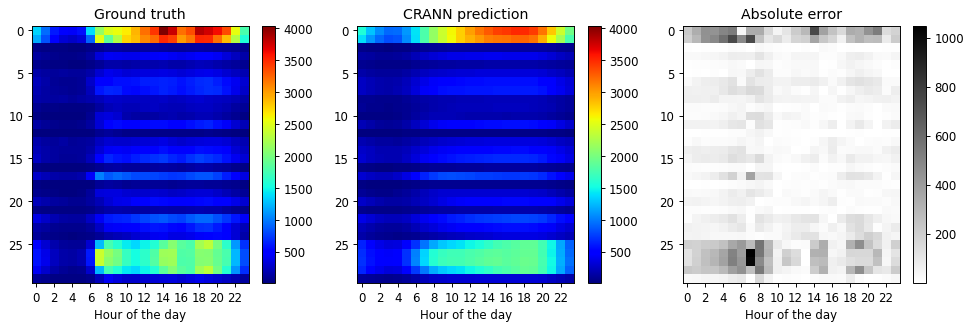

In [ ]:
real = y_tstep.mean(0)
prediction = y_pred_tstep.mean(0)

plt.figure('Example', figsize=(14, 4), dpi=85)

plt.subplot(1, 3, 1)
plt.imshow(real.T,  vmin = real.min(), vmax = real.max(), aspect='auto', cmap='jet')
plt.xticks(np.arange(0, 24, 2))
#plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Hour of the day')
plt.colorbar()
plt.title('Ground truth')

plt.subplot(1, 3, 2)
plt.imshow(prediction.T,  vmin = real.min(), vmax = real.max(), aspect='auto', cmap='jet')
plt.xticks(np.arange(0, 24, 2))
#plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Hour of the day')
plt.colorbar()
plt.title('CRANN prediction')

plt.subplot(1, 3, 3)
plt.imshow(real.sub(prediction).abs().T, aspect='auto', cmap='gray_r')
plt.xticks(np.arange(0, 24, 2))
#plt.yticks(np.arange(0, 30, 1))
plt.xlabel('Hour of the day')
plt.colorbar()
plt.title('Absolute error')

Learning curve

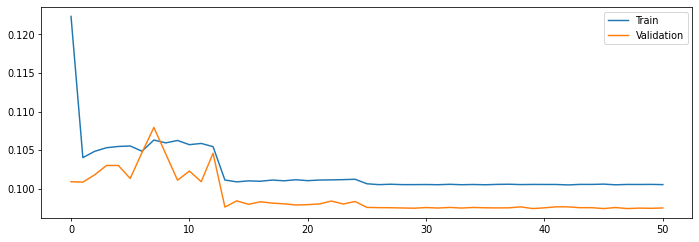

In [ ]:
plt.figure('Error', figsize=(12, 4), dpi=70)
plt.plot(np.sqrt(logs['train.mse']), label = 'Train')
plt.plot(np.sqrt(logs['val.mse']), label = 'Validation')
plt.legend()


Temporal RMSE distribution: hour

Text(0.5, 0, 'Hour of the day')

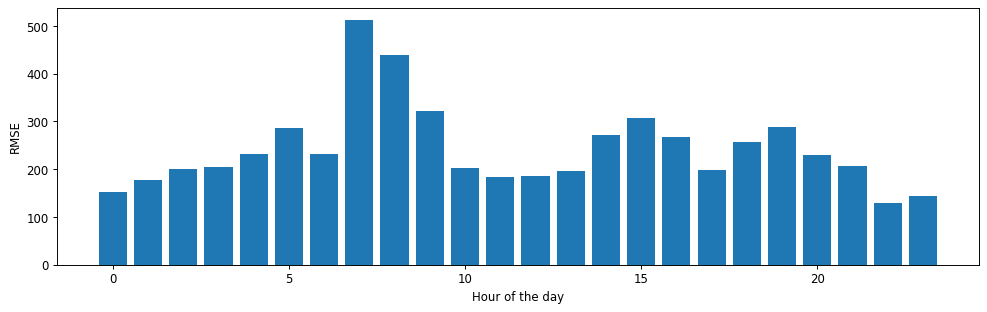

In [ ]:
plt.figure('RMSE dist hour', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_tstep,y_tstep, dim=2))
plt.ylabel('RMSE')
plt.xlabel('Hour of the day')

Temporal RMSE distribution: timestep

Text(0.5, 0, 'Timestep')

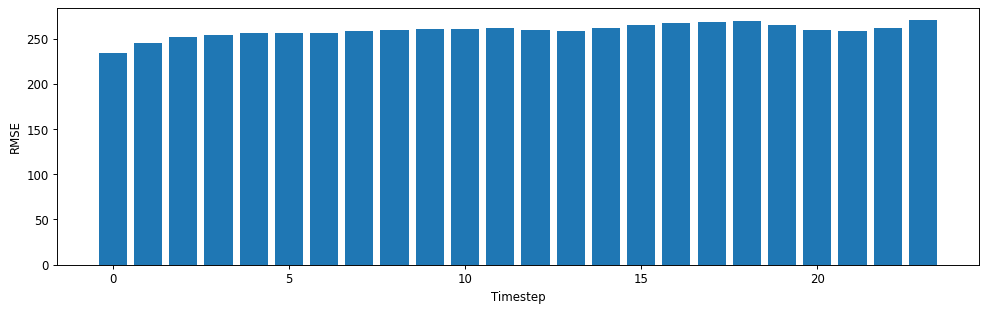

In [ ]:
plt.figure('RMSE dist timestep', figsize=(14, 4), dpi=85)
plt.bar(x = range(0,24),height = rmse(y_pred_dnorm, y_dnorm, dim=2))
plt.ylabel('RMSE')
plt.xlabel('Timestep')

Spatial RMSE distribution

Text(0.5, 0, 'Sensor')

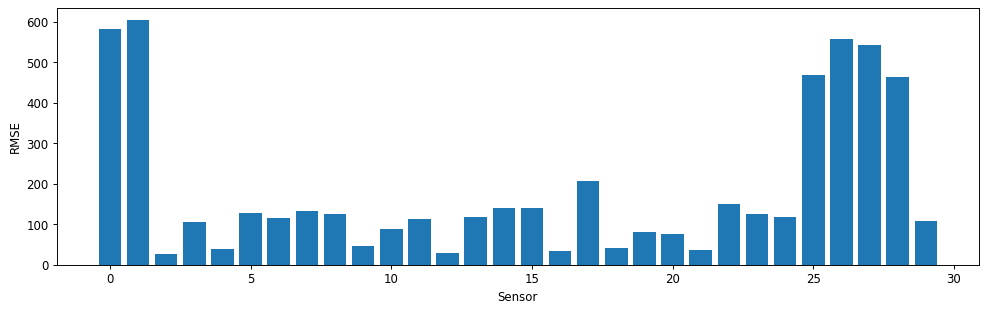

In [ ]:
plt.figure('RMSE dist spatial', figsize=(14, 4), dpi=85)
plt.bar(x = np.arange(0,30),height = rmse(y_pred_dnorm,y_dnorm, dim=1))
plt.ylabel('RMSE')
plt.xlabel('Sensor')